This notebook explores eva.ru forum users authorship attributes and segments users in clusters. The most important authorship attributes are selected at the end.

After the 
posts were downloaded from the forum, authorship attributes were precalculated in several separate notebooks: 

- Add Number of Child Messages.ipynb
- Transformers Sentiment Analysis.ipynb
- TextExtendedAttributes_FeatureEngineering.ipynb
- Authors.ipynb


# Libraries and data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pandas as pd
import numpy as np
import random

from sklearn.preprocessing import MinMaxScaler

# Visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

# Dimensionality reduction
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

In [ ]:
#Import a package to manage the warnings and ignore them
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)

In [ ]:
Data='/content/drive/MyDrive/Colab Notebooks/Projects/eva/Data/'

Authors_filename='Authors.csv'
Authors_full_filename=os.path.join(Data, Authors_filename)

CoreAuthors_filename='CoreAuthors.csv'
CoreAuthors_full_filename=os.path.join(Data, CoreAuthors_filename)

In [ ]:
Authors = pd.read_csv(Authors_full_filename, error_bad_lines=False, index_col=False) 

In [ ]:
Authors.columns.tolist()

['Author_Id',
 'author',
 'cnt_messages',
 'First_Message_Id',
 'Last_Message_Id',
 'first_message_ts',
 'last_message_ts',
 'Binned Number of Messages',
 'cnt_2021_messages',
 'num_of_tneg_messages',
 'num_of_100w_messages',
 'fraction_of_tneg_messages',
 'num_of_tpos_messages',
 'fraction_of_tpos_messages',
 'cnt_topics_started',
 'Num_Large_Topics',
 'fraction_of_Large_Topics',
 'cnt_immediate_responses',
 'posts_with_immediate_responses',
 'fraction_of_messages_with_immediate_responses',
 'avg_immediate_responses',
 'cnt_messages_with_discussion',
 'fraction_of_messages_with_discussion',
 'cnt_responses',
 'avg_responses',
 'cnt_of_neg_rersponses',
 'fraction_of_neg_rersponses',
 'cnt_of_pos_rersponses',
 'fraction_of_pos_rersponses',
 'TotalDays',
 'DaysWithMessages',
 'avg_messages_per_day',
 'Period1',
 'Period2',
 'Period3',
 'avg_messages_per_day_Period1',
 'avg_messages_per_day_Period2',
 'avg_messages_per_day_Period3',
 'PeriodDailyPeriodicityDetailed',
 'PeriodDailyPeriodic

To research authors style we need complete messages, not just short posts to agree/disagree with a previous post or long messages which are usually Copy&Paste from somewhere

It also makes sense to take into account only users with significant amount of messages (>100) to have enough data to analyze

Both conditions can be checked using 'cnt_medium_messages' column which was built based on medium messages only.

Subset of the forum core users (CoreAuthors) is separated for the further analysis.

From more then 20,000 who mostly publish posts as anonymous we get 2,474 users to analyze. They are also easily recognized by other forum users due to the volume of posts.

In [ ]:
CoreAuthors = Authors[Authors['cnt_medium_messages']>100].copy(deep=True)

In [ ]:
len(CoreAuthors)

2474

In [ ]:
CoreAuthors[['Author_Id','author','first_message_ts', 'last_message_ts','cnt_messages','cnt_medium_messages']].sort_values('cnt_medium_messages', ascending=False).head(20)

,Author_Id,author,first_message_ts,last_message_ts,cnt_messages,cnt_medium_messages
564,16035,ВесНа 16035 OH*,2009-02-06 15:33:00,2021-09-10 22:52:00,79541,66028.0
4795,90820,Utra Tumannaja OH*,2009-08-07 09:39:00,2021-07-15 19:10:00,66213,60102.0
6500,116852,Мизерикордия ♧* Clair,2009-08-10 13:47:00,2021-08-03 11:37:00,48987,41380.0
10678,191294,Старая Кошелка H*,2009-08-09 19:05:00,2021-08-04 02:16:00,45868,39848.0
2067,47934,Artemis D'Efes SD**,2009-07-17 11:24:00,2021-09-15 01:40:00,43106,37812.0
6798,121554,Kobra_I H*,2009-08-11 00:00:00,2018-02-11 20:39:00,44340,35961.0
4131,80099,"""""""-"""""" H*",2009-08-10 08:28:00,2021-07-03 00:15:00,40723,33934.0
11894,218916,Inga_groza H*,2010-12-01 15:21:00,2021-08-04 15:36:00,35660,30217.0
312,8938,Ioulia OH*,2009-08-18 16:28:00,2021-09-04 10:38:00,30794,27813.0
1215,32994,Птичка-невеличкa D,2009-07-23 09:30:00,2017-06-29 20:23:00,31956,27320.0


# Explaratory Data Analysis

## Grouping users by number of messages.

In [ ]:
bins = [100, 1000, 5000,100000]
CoreAuthors['Binned Number of Messages']=pd.cut(CoreAuthors['cnt_medium_messages'], bins=bins)
CoreAuthors.groupby('Binned Number of Messages').size().reset_index(name='Count Authors')

,Binned Number of Messages,Count Authors
0,"(100, 1000]",1882
1,"(1000, 5000]",458
2,"(5000, 100000]",134


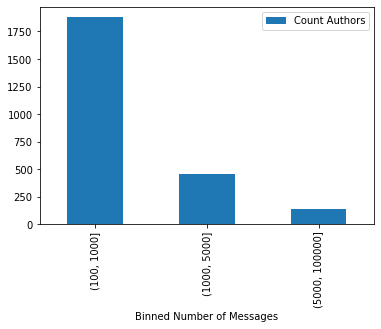

In [ ]:
CoreAuthors.groupby('Binned Number of Messages').size().reset_index(name='Count Authors').plot.bar(x='Binned Number of Messages', y='Count Authors')

In [ ]:
bins = [10, 20, 50,100,10000]
CoreAuthors['Binned Number of Words']=pd.cut(CoreAuthors['cnt_medium_messages'], bins=bins)
CoreAuthors.groupby('Binned Number of Messages').size().reset_index(name='Count Authors')

,Binned Number of Messages,Count Authors
0,"(100, 1000]",1882
1,"(1000, 5000]",458
2,"(5000, 100000]",134


In [ ]:
def plot_corr(df):
    corr = df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

## The first group of attributes is how positive or negative users messages and how other forum participants react(respond).

### Fraction of negative posts based on "tatyana"  method sentiment analysis.

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Negative posts')
CoreAuthors[['fraction_of_tneg_messages']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_tneg_messages']].hist(ax=axes[1], bins=100)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f317f1890>],
      dtype=object)

### Fraction of positive posts based on "tatyana"  method sentiment analysis.

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Positive posts')
CoreAuthors[['fraction_of_tpos_messages']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_tpos_messages']].hist(ax=axes[1], bins=100)

### Average number of direct responses to users posts

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Average number of direct responses to authors posts')
CoreAuthors[['avg_immediate_responses']].boxplot(ax=axes[0])
CoreAuthors[['avg_immediate_responses']].hist(ax=axes[1], bins=100)

### Fraction of users posts with direct responses

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f311f5490>],
      dtype=object)

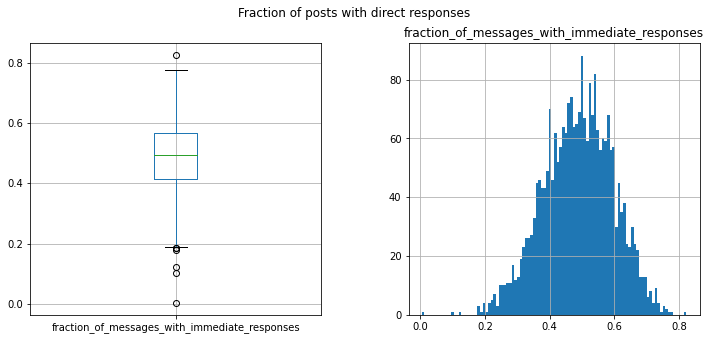

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Fraction of posts with direct responses')
CoreAuthors[['fraction_of_messages_with_immediate_responses']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_messages_with_immediate_responses']].hist(ax=axes[1], bins=100)

Left long tail means more authors with very little responses

### Average number of responses in a topic branches started by a user.
(Responses to responses)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f316085d0>],
      dtype=object)

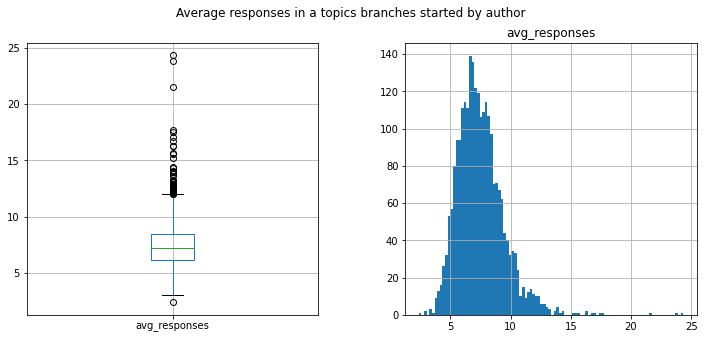

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Average responses in a topics branches started by author')
CoreAuthors[['avg_responses']].boxplot(ax=axes[0])
CoreAuthors[['avg_responses']].hist(ax=axes[1], bins=100)

Long right tail says about authors with really long branches/discussion. In other words, they can say something really interesting.

### Fraction of users posts which starts a branch in a topic to discuss something specific.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f30e103d0>],
      dtype=object)

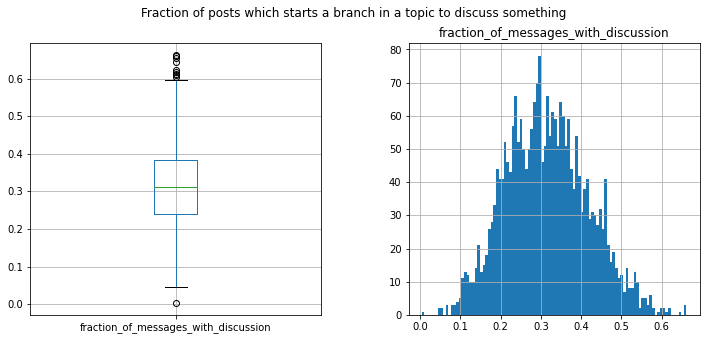

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Fraction of posts which starts a branch in a topic to discuss something')
CoreAuthors[['fraction_of_messages_with_discussion']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_messages_with_discussion']].hist(ax=axes[1], bins=100)

### How many large topics were created by user?
(Topic is a large one if there are more messages then in average in a forum chapter)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f30d12a50>],
      dtype=object)

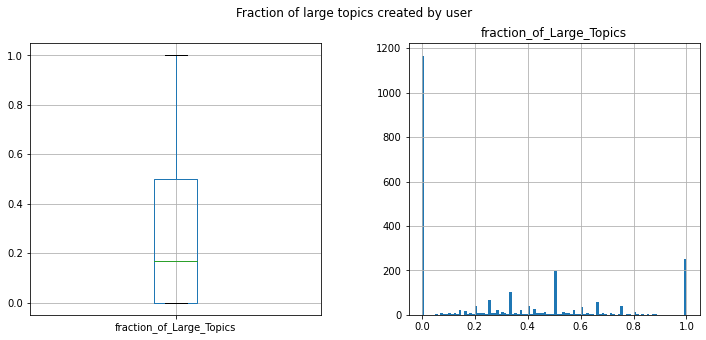

In [ ]:

fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Fraction of large topics created by user')
CoreAuthors[['fraction_of_Large_Topics']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_Large_Topics']].hist(ax=axes[1], bins=100)

### How many negative responses to authors posts?
(based on "tatyana" method sentiment analysis.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f30aa1450>],
      dtype=object)

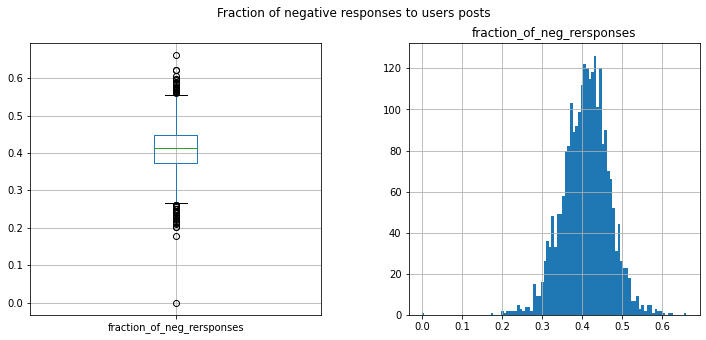

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Fraction of negative responses to users posts')
CoreAuthors[['fraction_of_neg_rersponses']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_neg_rersponses']].hist(ax=axes[1], bins=100)

### How many positive responses to authors posts?
(based on "tatyana" method sentiment analysis.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f30843450>],
      dtype=object)

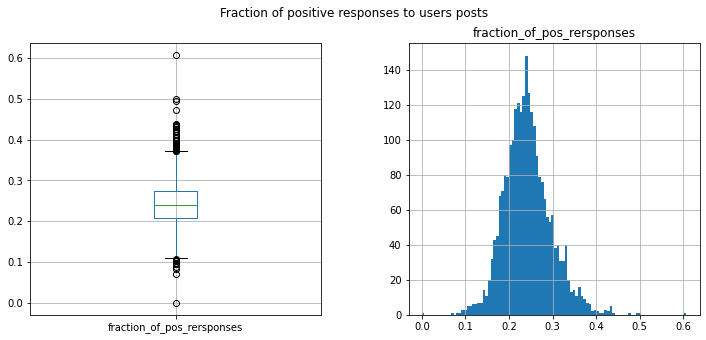

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Fraction of positive responses to users posts')
CoreAuthors[['fraction_of_pos_rersponses']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_pos_rersponses']].hist(ax=axes[1], bins=100)

### Correlation between all attributes reviewed so far:

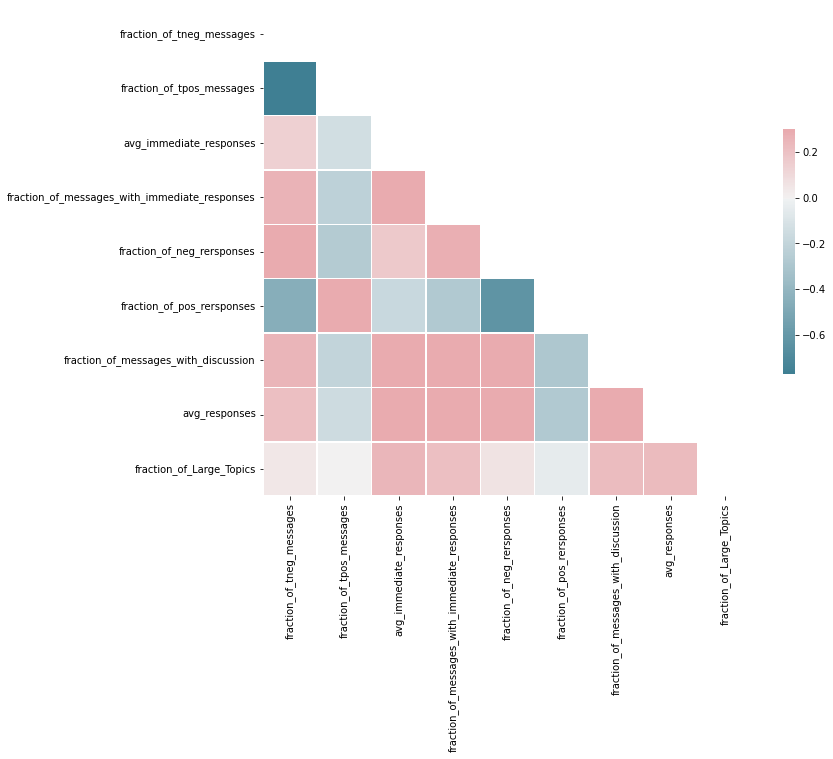

In [ ]:
plot_corr(CoreAuthors[[ 'fraction_of_tneg_messages',
                       'fraction_of_tpos_messages',
                       'avg_immediate_responses',
                       'fraction_of_messages_with_immediate_responses',
                       'fraction_of_neg_rersponses',
                       'fraction_of_pos_rersponses',
                       'fraction_of_messages_with_discussion',
                       'avg_responses',
                       'fraction_of_Large_Topics']])

The level of the correlation is not high but it's clear, that positive messages have less reaction (responses) then negative. There are more positive responses to positive messages and less negative. Negative messages power more discussion, more negative responses and less positive responses.

### Average number of emojies, images and links is very close to 0 but there are distinct authors

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f30d1e150>],
      dtype=object)

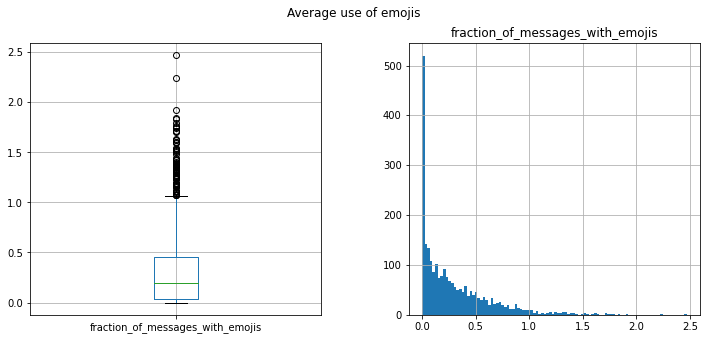

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Average use of emojis')
CoreAuthors[['fraction_of_messages_with_emojis']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_messages_with_emojis']].hist(ax=axes[1], bins=100)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f27af7ed0>],
      dtype=object)

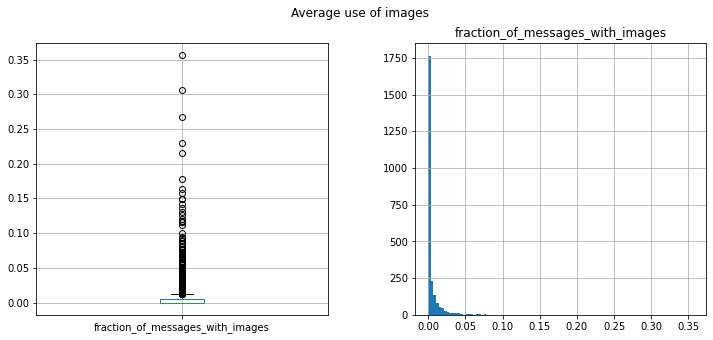

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Average use of images')
CoreAuthors[['fraction_of_messages_with_images']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_messages_with_images']].hist(ax=axes[1], bins=100)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f27b59ad0>],
      dtype=object)

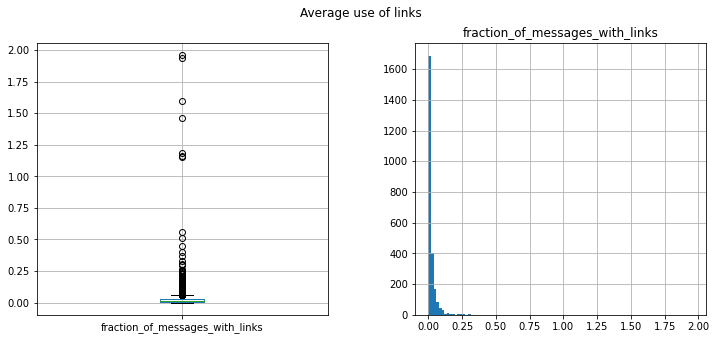

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Average use of links')
CoreAuthors[['fraction_of_messages_with_links']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_messages_with_links']].hist(ax=axes[1], bins=100)

### Average number of sentences and sentence length

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f277438d0>],
      dtype=object)

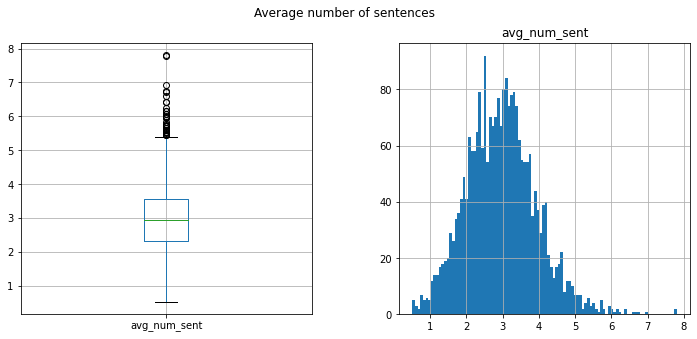

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Average number of sentences')
CoreAuthors[['avg_num_sent']].boxplot(ax=axes[0])
CoreAuthors[['avg_num_sent']].hist(ax=axes[1], bins=100)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f27548310>],
      dtype=object)

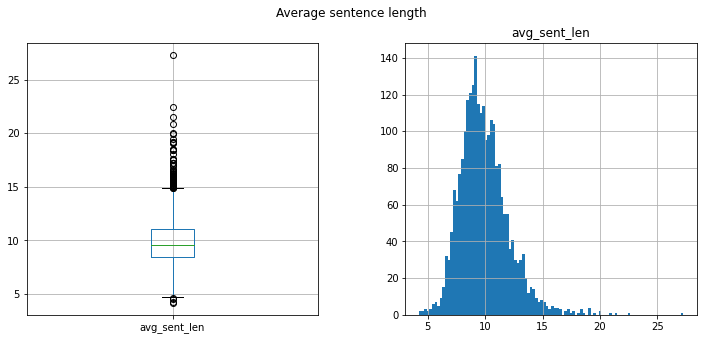

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Average sentence length')
CoreAuthors[['avg_sent_len']].boxplot(ax=axes[0])
CoreAuthors[['avg_sent_len']].hist(ax=axes[1], bins=100)

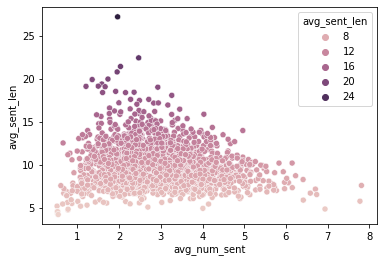

In [ ]:
sns.scatterplot(CoreAuthors.avg_num_sent, CoreAuthors.avg_sent_len, CoreAuthors.avg_sent_len)

On average, small number of long sentences may say about missed periods which is a distinct sighn of some authors styles.

### Average word length and percent of long words

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f27be5450>],
      dtype=object)

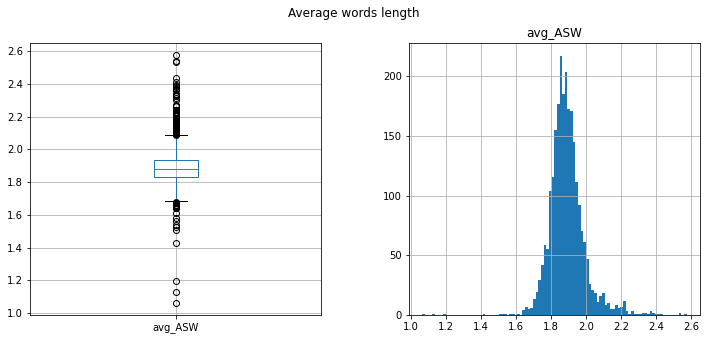

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Average words length')
CoreAuthors[['avg_ASW']].boxplot(ax=axes[0])
CoreAuthors[['avg_ASW']].hist(ax=axes[1], bins=100)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f25944490>],
      dtype=object)

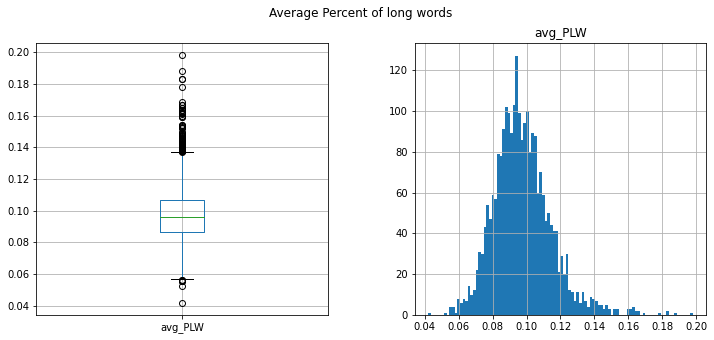

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Average Percent of long words')
CoreAuthors[['avg_PLW']].boxplot(ax=axes[0])
CoreAuthors[['avg_PLW']].hist(ax=axes[1], bins=100)

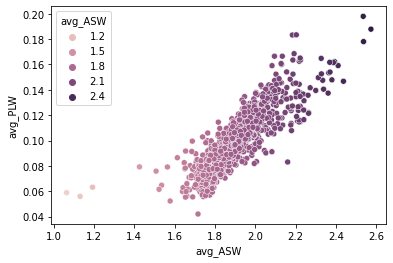

In [ ]:
sns.scatterplot(CoreAuthors.avg_ASW, CoreAuthors.avg_PLW, CoreAuthors.avg_ASW)

Consistent use of short words only can say about a simplified language for whatever reason

### Commas usage in the posts

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f257483d0>],
      dtype=object)

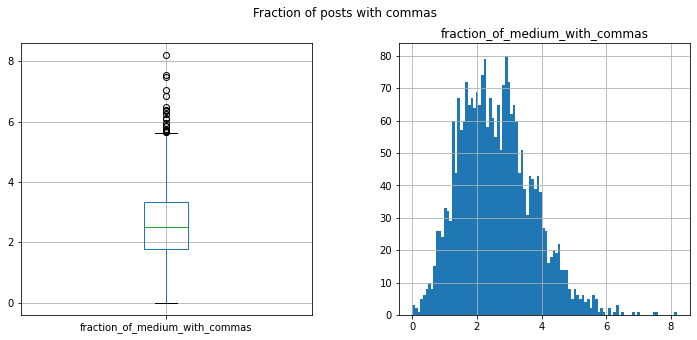

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Fraction of posts with commas')
CoreAuthors[['fraction_of_medium_with_commas']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_medium_with_commas']].hist(ax=axes[1], bins=100)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f254ade90>],
      dtype=object)

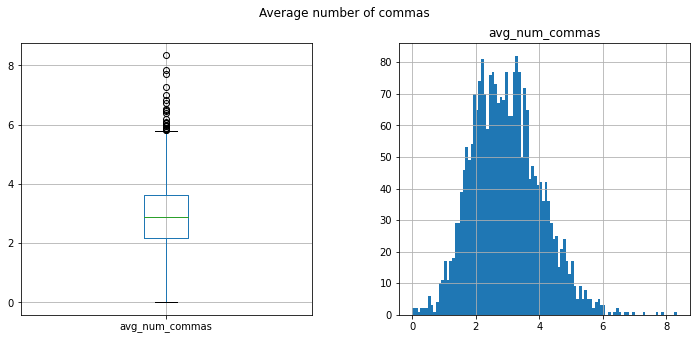

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Average number of commas')
CoreAuthors[['avg_num_commas']].boxplot(ax=axes[0])
CoreAuthors[['avg_num_commas']].hist(ax=axes[1], bins=100)

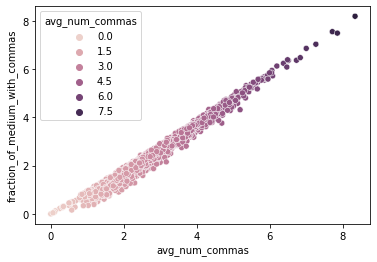

In [ ]:
sns.scatterplot(CoreAuthors.avg_num_commas, CoreAuthors.fraction_of_medium_with_commas, CoreAuthors.avg_num_commas)

Less or no commas means more simple langauge or missed commas due to emotions or whatever. That's definetly characterizes some authors.

## Excessive exclamations (!!!!), questions (????) or other (?!!! !???)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f2526a3d0>],
      dtype=object)

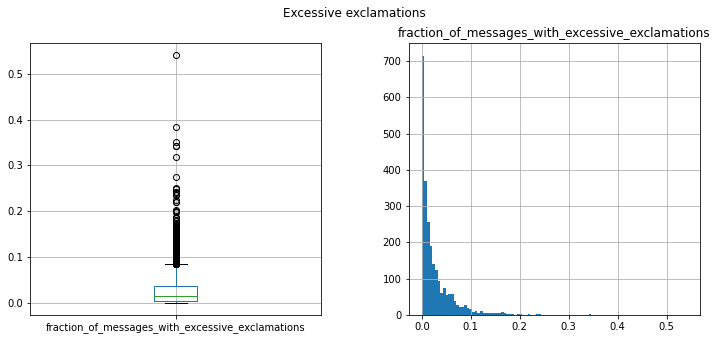

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Excessive exclamations')
CoreAuthors[['fraction_of_messages_with_excessive_exclamations']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_messages_with_excessive_exclamations']].hist(ax=axes[1], bins=100)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f2503d210>],
      dtype=object)

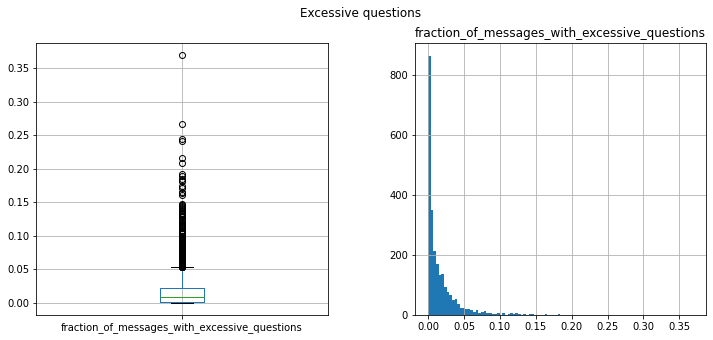

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Excessive questions')
CoreAuthors[['fraction_of_messages_with_excessive_questions']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_messages_with_excessive_questions']].hist(ax=axes[1], bins=100)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f24e27090>],
      dtype=object)

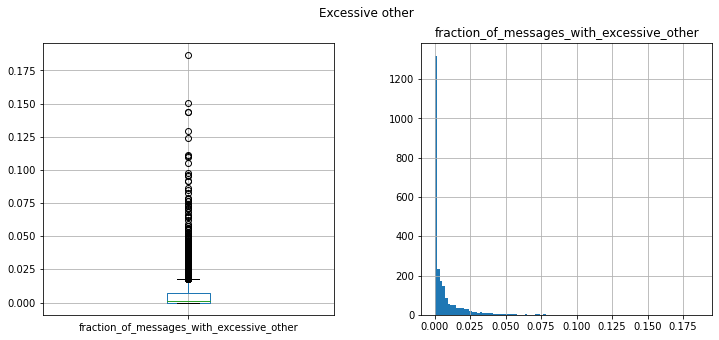

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Excessive other')
CoreAuthors[['fraction_of_messages_with_excessive_other']].boxplot(ax=axes[0])
CoreAuthors[['fraction_of_messages_with_excessive_other']].hist(ax=axes[1], bins=100)

Most of authors do not use excessive exclamations or question marks. But there are some authors who use them a lot.

## Using adjective by different authors

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f24c59190>],
      dtype=object)

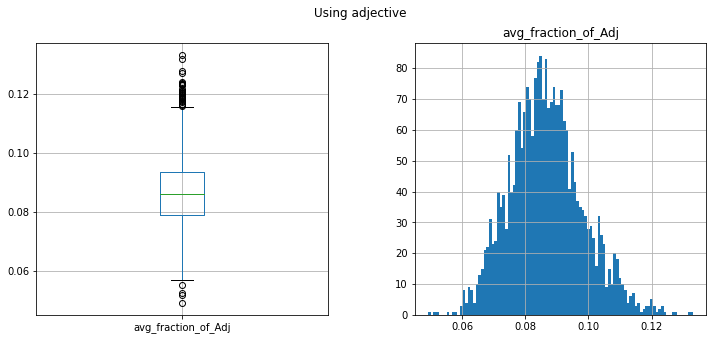

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Using adjective')
CoreAuthors[['avg_fraction_of_Adj']].boxplot(ax=axes[0])
CoreAuthors[['avg_fraction_of_Adj']].hist(ax=axes[1], bins=100)

### Using nouns by different authors

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f24a4da50>],
      dtype=object)

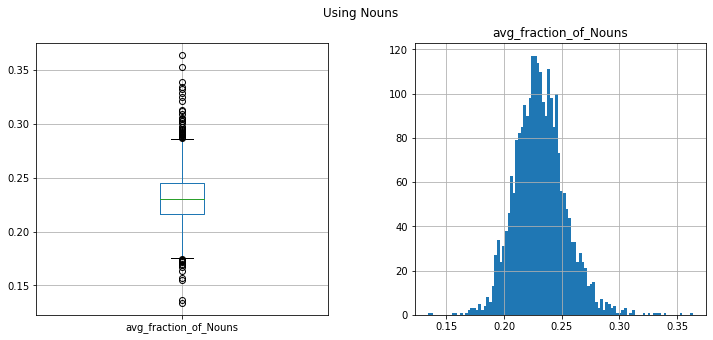

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Using Nouns')
CoreAuthors[['avg_fraction_of_Nouns']].boxplot(ax=axes[0])
CoreAuthors[['avg_fraction_of_Nouns']].hist(ax=axes[1], bins=100)

### Using verbs by different authors

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f248db750>],
      dtype=object)

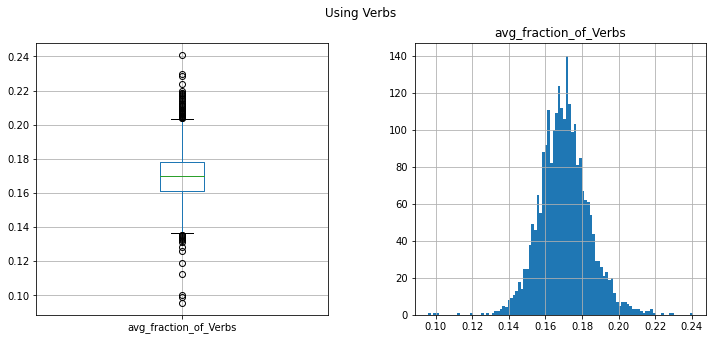

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Using Verbs')
CoreAuthors[['avg_fraction_of_Verbs']].boxplot(ax=axes[0])
CoreAuthors[['avg_fraction_of_Verbs']].hist(ax=axes[1], bins=100)

## Other coefficients related to Adjectives, Nouns and Verbs

### TTR - type token ratio is a fraction of unique tokens (num_tokens=num_Adj + num_Nouns + num_Verb) in a message to all recognized adjective, nouns and verbs(num_tokens=num_Adj + num_Nouns + num_Verb): num_unique_tokens/num_tokens

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f24680190>],
      dtype=object)

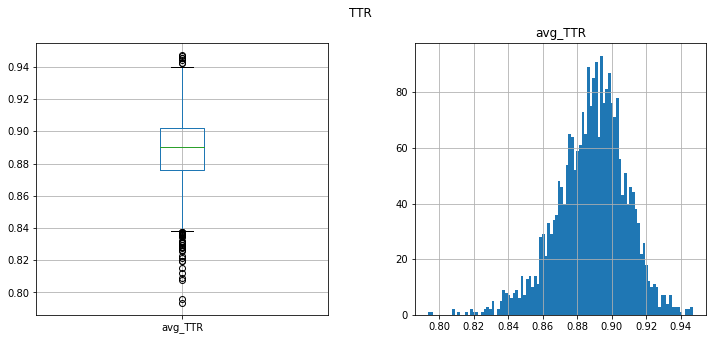

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('TTR')
CoreAuthors[['avg_TTR']].boxplot(ax=axes[0])
CoreAuthors[['avg_TTR']].hist(ax=axes[1], bins=100)

### TTR_A - fraction of unique recognized adjectives in a message to all recognized adjective: TTR_A = num_unique_Adj/num_Adj

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f24463050>],
      dtype=object)

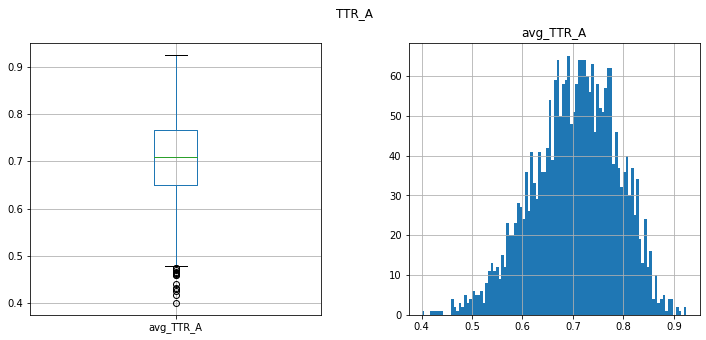

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('TTR_A')
CoreAuthors[['avg_TTR_A']].boxplot(ax=axes[0])
CoreAuthors[['avg_TTR_A']].hist(ax=axes[1], bins=100)

### TTR_N - fraction of unique recognized nouns in a message to all recognized nouns: num_unique_Nouns/num_Nouns

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f242d1990>],
      dtype=object)

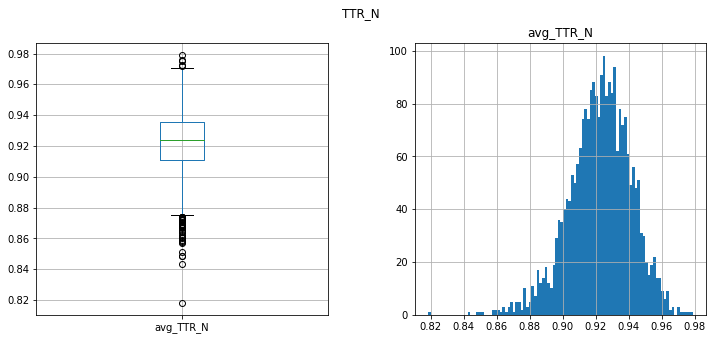

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('TTR_N')
CoreAuthors[['avg_TTR_N']].boxplot(ax=axes[0])
CoreAuthors[['avg_TTR_N']].hist(ax=axes[1], bins=100)

### TTR_V - fraction of unique recognized verbs in a message to all recognized verbs: num_unique_Verb/num_Verb

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f24088a10>],
      dtype=object)

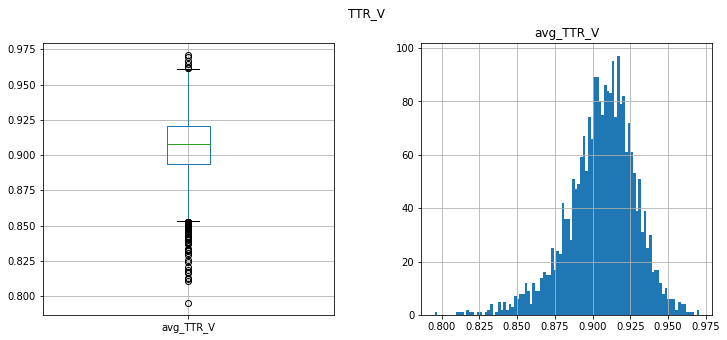

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('TTR_V')
CoreAuthors[['avg_TTR_V']].boxplot(ax=axes[0])
CoreAuthors[['avg_TTR_V']].hist(ax=axes[1], bins=100)

### NAV - fraction of recognized adjective and nouns to verbs: NAV = (TTR_A +TTR_N)/TTR_V

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f23e8ae90>],
      dtype=object)

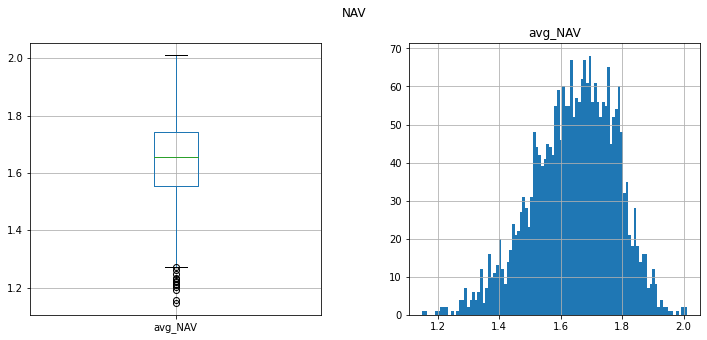

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('NAV')
CoreAuthors[['avg_NAV']].boxplot(ax=axes[0])
CoreAuthors[['avg_NAV']].hist(ax=axes[1], bins=100)

### UNAV - fraction of recognized unique adjective and unique nouns to unique verbs: UNAV = (num_unique_Adj +num_unique_Nouns)/num_unique_Verb

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f2594f210>],
      dtype=object)

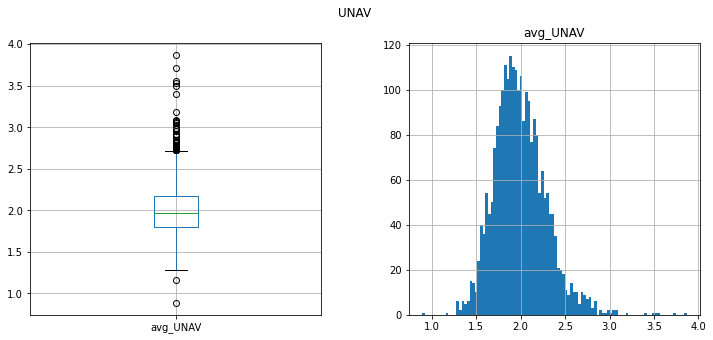

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('UNAV')
CoreAuthors[['avg_UNAV']].boxplot(ax=axes[0])
CoreAuthors[['avg_UNAV']].hist(ax=axes[1], bins=100)

Usage of recognized adjective, nouns and verbs can say a lot how complex or simplified language authors use. Some of them can make mistake and a word is not recognized at all, the others use a lot of adjective using very reach language. Some users can use english words typing them cyrillic characters and they are also not recognizable, etc

## Text Formatting - paragrgaphs

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f23a8ccd0>],
      dtype=object)

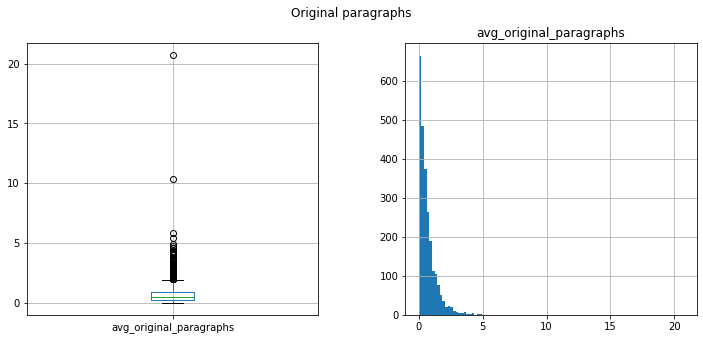

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Original paragraphs')
CoreAuthors[['avg_original_paragraphs']].boxplot(ax=axes[0])
CoreAuthors[['avg_original_paragraphs']].hist(ax=axes[1], bins=100)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f2389b410>],
      dtype=object)

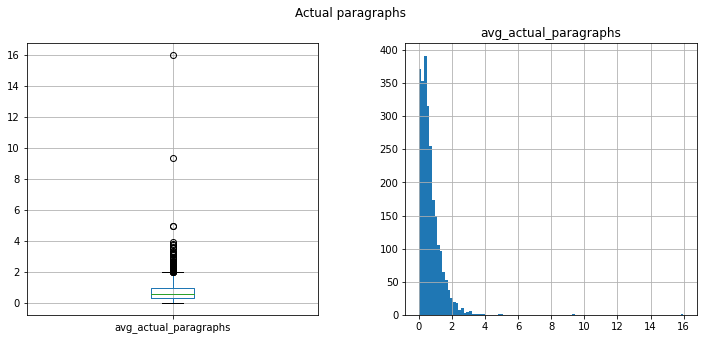

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Actual paragraphs')
CoreAuthors[['avg_actual_paragraphs']].boxplot(ax=axes[0])
CoreAuthors[['avg_actual_paragraphs']].hist(ax=axes[1], bins=100)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f4f23673290>],
      dtype=object)

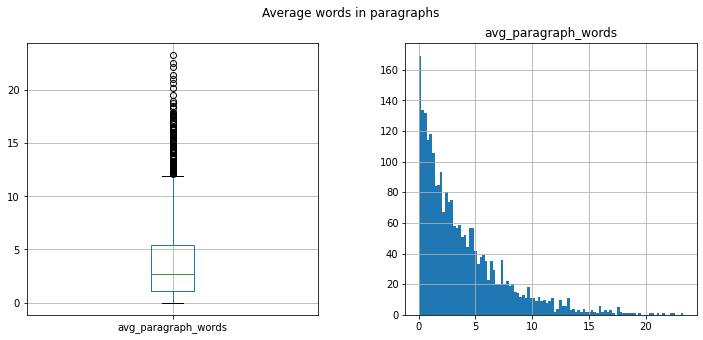

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 5), sharey=False)
fig.suptitle('Average words in paragraphs')
CoreAuthors[['avg_paragraph_words']].boxplot(ax=axes[0])
CoreAuthors[['avg_paragraph_words']].hist(ax=axes[1], bins=100)

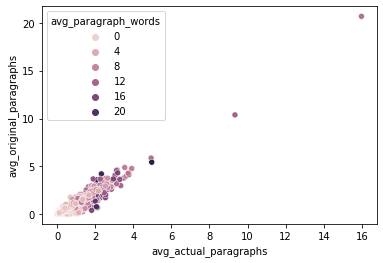

In [ ]:
sns.scatterplot(CoreAuthors.avg_actual_paragraphs, CoreAuthors.avg_original_paragraphs, CoreAuthors.avg_paragraph_words)

There are some authors who use double space between paragraphs. But after all, I decided do not include paragraph related attributes because they are related to posts length and I do not want to segment users based on the number of posts or their length.

## Clustering

In [ ]:
df = CoreAuthors[[
'fraction_of_tneg_messages',
'fraction_of_tpos_messages',
'fraction_of_Large_Topics',
'fraction_of_messages_with_immediate_responses',
'avg_immediate_responses',
'fraction_of_messages_with_discussion',
'avg_responses',
'fraction_of_neg_rersponses',
'fraction_of_pos_rersponses',
'fraction_of_messages_with_emojis',
'fraction_of_messages_with_images',
'fraction_of_messages_with_links',
#'avg_original_paragraphs',
#'avg_actual_paragraphs',
#'avg_paragraph_words',
'fraction_of_messages_with_excessive_exclamations',
'fraction_of_messages_with_excessive_questions',
'fraction_of_messages_with_excessive_other',
'fraction_of_medium_with_commas',
'avg_num_commas',
'avg_sent_len',
'avg_num_sent',
'avg_ASW',
'avg_PLW',
'avg_fraction_of_Adj',
'avg_fraction_of_Verbs',
'avg_fraction_of_Nouns',
'avg_TTR',
'avg_TTR_A',
'avg_TTR_N',
'avg_TTR_V',
'avg_NAV',
'avg_UNAV'
]].copy(deep=True)

# Normalized k-Means

k-Means clustering  typically uses Euclidean distance to calculate the distances but it does not work well with high dimensional data and we have 30 dim. A solution would be to use the Cosine distance which works better in high dimensional space. Since Cosine distance and Euclidean distance are connected linearly for normalized vectors we can simply normalize our data.

## Optimal number of clusters

Text(0.5, 1.0, 'Inertia of Cosine k-Means versus number of clusters')

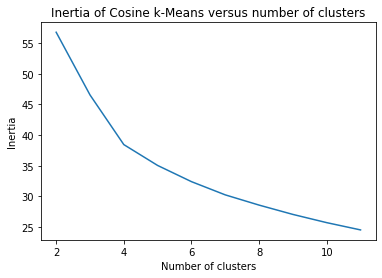

In [ ]:
normalized_vectors = preprocessing.normalize(df)
scores = [KMeans(n_clusters=i+2).fit(normalized_vectors).inertia_ for i in range(10)]
sns.lineplot(np.arange(2, 12), scores)
plt.xlabel('Number of clusters')
plt.ylabel("Inertia")
plt.title("Inertia of Cosine k-Means versus number of clusters")

According to elbow method we selected k=4 clusters to be generated using normalized k-Means.

## Clustering

In [ ]:
normalized_kmeans = KMeans(n_clusters=4)
normalized_kmeans.fit(normalized_vectors)

KMeans(n_clusters=4)

# Visualization

## PCA

In [ ]:
def prepare_pca(n_components, data, cluster_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = cluster_labels
    return df_matrix

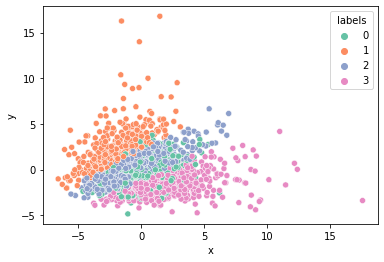

In [ ]:
pca_df = prepare_pca(3, df, normalized_kmeans.labels_)
sns.scatterplot(x=pca_df.x, y=pca_df.y, hue=pca_df.labels, palette="Set2")

## t-SNE

In [ ]:
def prepare_tsne(n_components, data, cluster_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = cluster_labels
    
    return df_matrix

In [ ]:
normalized_kmeans_tsne_3d_df = prepare_tsne(3, df, normalized_kmeans.labels_)

## 3D Animation

In [ ]:
def plot_animation(df, label_column, name):
    def update(num):
        ax.view_init(200, num)

    N=360
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['x'], df['y'], df['z'], c=df[label_column],
               s=6, depthshade=True, cmap='Paired')
    ax.set_zlim(-15, 25)
    ax.set_xlim(-20, 20)
    plt.tight_layout()
    ani = animation.FuncAnimation(fig, update, N, blit=False, interval=50)
    plt.show()

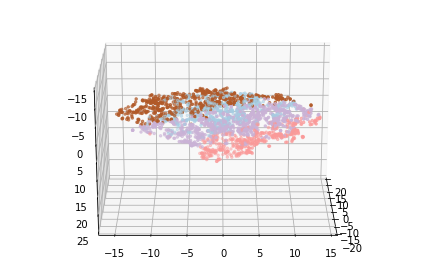

In [ ]:
plot_animation(normalized_kmeans_tsne_3d_df, 'labels', 'normalized_kmeans')

# Evaluation

In [ ]:
CoreAuthors['normalized_kmeans']=normalized_kmeans.labels_

## What makes a cluster unique?

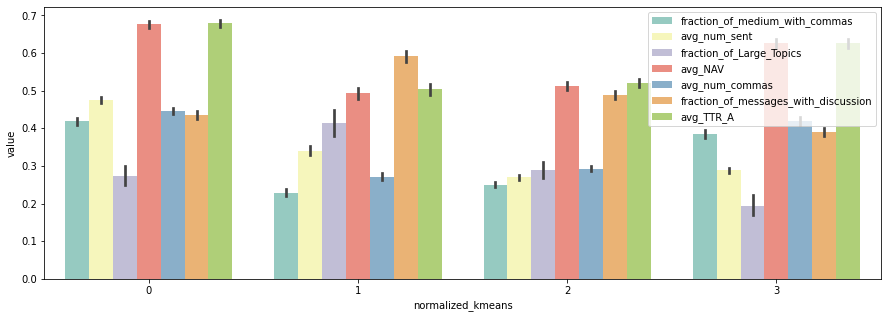

In [ ]:
# Setting all variables between 0 and 1 in order to better visualize the results

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df))
df_scaled.columns = df.columns
df_scaled['normalized_kmeans'] = normalized_kmeans.labels_

# Calculate variables with largest differences (by standard deviation)
# The higher the standard deviation in a variable based on average values for each cluster
# The more likely that the variable is important when creating the cluster
df_mean = df_scaled.loc[normalized_kmeans.labels_!=-1, :].groupby('normalized_kmeans').mean().reset_index()
results = pd.DataFrame(columns=['Variable', 'Std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('Std', ascending=False).head(7).Variable.values) + ['normalized_kmeans']

# Plot data
tidy = df_scaled[selected_columns].melt(id_vars='normalized_kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='normalized_kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper right')

# Most important authorship attributes:

- How many posts with commas (fraction_of_medium_with_commas)
- Average number of sentences (avg_num_sent)
- How many large topics were created by user (topics with number of posts more then average in a forum chapter) (fraction_of_Large_Topics)
- Average by all posts fraction of recognized adjective and nouns to verbs: NAV = (TTR_A +TTR_N)/TTR_V (avg_NAV)
- average number of commas (avg_num_commas)
- How many posts with discussions (start a branch in a topic to discuss something) (fraction_of_messages_with_discussion)
- Average by all posts TTR_A - fraction of unique recognized adjectives in a message to all recognized adjective: TTR_A = num_unique_Adj/num_Adj

Looks like adjectives are more important then verbs or nouns.

In [ ]:
CoreAuthors[['Author_Id','author','first_message_ts', 'last_message_ts','cnt_messages','cnt_medium_messages','normalized_kmeans']].sort_values('cnt_messages', ascending=False).head(20)

,Author_Id,author,first_message_ts,last_message_ts,cnt_messages,cnt_medium_messages,normalized_kmeans
564,16035,ВесНа 16035 OH*,2009-02-06 15:33:00,2021-09-10 22:52:00,79541,66028.0,1
4795,90820,Utra Tumannaja OH*,2009-08-07 09:39:00,2021-07-15 19:10:00,66213,60102.0,2
6500,116852,Мизерикордия ♧* Clair,2009-08-10 13:47:00,2021-08-03 11:37:00,48987,41380.0,1
10678,191294,Старая Кошелка H*,2009-08-09 19:05:00,2021-08-04 02:16:00,45868,39848.0,2
6798,121554,Kobra_I H*,2009-08-11 00:00:00,2018-02-11 20:39:00,44340,35961.0,0
2067,47934,Artemis D'Efes SD**,2009-07-17 11:24:00,2021-09-15 01:40:00,43106,37812.0,1
4131,80099,"""""""-"""""" H*",2009-08-10 08:28:00,2021-07-03 00:15:00,40723,33934.0,1
11894,218916,Inga_groza H*,2010-12-01 15:21:00,2021-08-04 15:36:00,35660,30217.0,1
1215,32994,Птичка-невеличкa D,2009-07-23 09:30:00,2017-06-29 20:23:00,31956,27320.0,2
312,8938,Ioulia OH*,2009-08-18 16:28:00,2021-09-04 10:38:00,30794,27813.0,2


In [ ]:
CoreAuthors.to_csv(CoreAuthors_full_filename, header=True, index=False)

## Cluster 0

In [ ]:
CoreAuthors[CoreAuthors['normalized_kmeans']==0][['Author_Id','author','first_message_ts', 'last_message_ts','cnt_messages','cnt_medium_messages','normalized_kmeans']].sort_values('cnt_messages', ascending=False)

,Author_Id,author,first_message_ts,last_message_ts,cnt_messages,cnt_medium_messages,normalized_kmeans
6798,121554,Kobra_I H*,2009-08-11 00:00:00,2018-02-11 20:39:00,44340,35961.0,0
1459,37424,Felinka OH*,2009-08-11 01:41:00,2021-09-18 01:42:00,30269,22621.0,0
12460,234431,ФсекозлихиЯкоролевна H*,2009-09-24 11:26:00,2021-08-06 19:51:00,13945,11277.0,0
828,24045,Кумпа моя H*,2008-11-09 16:50:00,2021-04-19 11:41:00,13564,10289.0,0
445,12518,Рrincess ♤* Clair,2009-08-23 21:52:00,2021-09-23 12:08:00,13071,11835.0,0
...,...,...,...,...,...,...,...
1212,32924,Krotik F,2009-08-24 22:00:00,2019-04-18 12:03:00,125,110.0,0
10290,183953,Dakinya F,2010-11-10 19:02:00,2016-07-08 18:04:00,125,107.0,0
5721,105538,Kleto4ka **,2009-08-18 10:41:00,2020-05-10 20:26:00,124,103.0,0
1129,30939,Saule D,2013-06-02 10:13:00,2019-11-23 18:23:00,123,104.0,0


## Cluster 1

In [ ]:
CoreAuthors[CoreAuthors['normalized_kmeans']==1][['Author_Id','author','first_message_ts', 'last_message_ts','cnt_messages','cnt_medium_messages','normalized_kmeans']].sort_values('cnt_messages', ascending=False)

,Author_Id,author,first_message_ts,last_message_ts,cnt_messages,cnt_medium_messages,normalized_kmeans
564,16035,ВесНа 16035 OH*,2009-02-06 15:33:00,2021-09-10 22:52:00,79541,66028.0,1
6500,116852,Мизерикордия ♧* Clair,2009-08-10 13:47:00,2021-08-03 11:37:00,48987,41380.0,1
2067,47934,Artemis D'Efes SD**,2009-07-17 11:24:00,2021-09-15 01:40:00,43106,37812.0,1
4131,80099,"""""""-"""""" H*",2009-08-10 08:28:00,2021-07-03 00:15:00,40723,33934.0,1
11894,218916,Inga_groza H*,2010-12-01 15:21:00,2021-08-04 15:36:00,35660,30217.0,1
...,...,...,...,...,...,...,...
10417,186159,ФедЮля **,2009-12-28 03:36:00,2010-02-19 03:26:00,119,105.0,1
8144,143472,Natasha707 D*,2009-09-25 14:28:00,2020-09-03 15:09:00,118,104.0,1
3602,71508,Cherrry *,2009-10-14 16:39:00,2010-08-17 00:51:00,116,104.0,1
1969,46095,Ушанка Псаки *,2010-07-27 15:13:00,2014-07-28 18:28:00,113,101.0,1


## Cluster 2

In [ ]:
CoreAuthors[CoreAuthors['normalized_kmeans']==2][['Author_Id','author','first_message_ts', 'last_message_ts','cnt_messages','cnt_medium_messages','normalized_kmeans']].sort_values('cnt_messages', ascending=False)

,Author_Id,author,first_message_ts,last_message_ts,cnt_messages,cnt_medium_messages,normalized_kmeans
4795,90820,Utra Tumannaja OH*,2009-08-07 09:39:00,2021-07-15 19:10:00,66213,60102.0,2
10678,191294,Старая Кошелка H*,2009-08-09 19:05:00,2021-08-04 02:16:00,45868,39848.0,2
1215,32994,Птичка-невеличкa D,2009-07-23 09:30:00,2017-06-29 20:23:00,31956,27320.0,2
312,8938,Ioulia OH*,2009-08-18 16:28:00,2021-09-04 10:38:00,30794,27813.0,2
17522,470105,mllerelena H*,2015-05-11 23:04:00,2021-08-14 23:03:00,30214,26082.0,2
...,...,...,...,...,...,...,...
9288,164919,Inaa D*,2009-10-09 20:25:00,2020-05-12 10:54:00,120,107.0,2
14061,273406,knatp KF,2011-02-09 22:21:00,2021-05-21 15:22:00,120,111.0,2
5525,102610,мама Тони F*,2010-02-17 10:27:00,2018-12-28 00:02:00,117,107.0,2
2089,48307,Hemul *,2010-04-17 21:54:00,2015-09-26 18:44:00,116,104.0,2


## Cluster 3

In [ ]:
CoreAuthors[CoreAuthors['normalized_kmeans']==3][['Author_Id','author','first_message_ts', 'last_message_ts','cnt_messages','cnt_medium_messages','normalized_kmeans']].sort_values('cnt_messages', ascending=False)

,Author_Id,author,first_message_ts,last_message_ts,cnt_messages,cnt_medium_messages,normalized_kmeans
16761,408251,Dezzi 408251 H*,2013-09-16 17:31:00,2021-09-12 08:26:00,11886,10256.0,3
2773,59282,Тиффа OH*,2009-08-18 13:15:00,2021-08-03 08:00:00,9981,8866.0,3
599,16999,Crazy Horse SD**,2010-02-19 00:15:00,2021-01-14 15:25:00,8017,6546.0,3
3741,73840,Leti-ka (c) SD*,2009-08-02 21:12:00,2020-06-10 18:05:00,7678,6232.0,3
3778,74486,З@я OH*,2009-08-13 23:10:00,2019-12-05 00:16:00,7384,6183.0,3
...,...,...,...,...,...,...,...
14411,283282,Красавище KF,2011-01-18 16:26:00,2020-03-24 13:06:00,119,103.0,3
4743,90183,игора F,2009-09-09 23:01:00,2018-03-23 09:15:00,119,107.0,3
4219,81468,Первоапрельская шутка *,2009-11-30 13:11:00,2014-09-29 15:23:00,118,109.0,3
6593,118218,Julа V.I.P.,2009-08-08 17:46:00,2013-07-15 19:54:00,117,106.0,3


## Potentional clones should be in the same cluster

### ФедЮля clones

In [ ]:
CoreAuthors[CoreAuthors['author'].str.contains('Фед')][['Author_Id','author','first_message_ts', 'last_message_ts','cnt_messages','cnt_medium_messages','normalized_kmeans']]

,Author_Id,author,first_message_ts,last_message_ts,cnt_messages,cnt_medium_messages,normalized_kmeans
10417,186159,ФедЮля **,2009-12-28 03:36:00,2010-02-19 03:26:00,119,105.0,1
13120,250487,ФедюлЯ +,2009-11-01 18:41:00,2010-02-22 16:43:00,5571,4530.0,1
13808,266936,ФедЮлЯ _,2010-03-16 18:53:00,2010-03-23 23:41:00,287,243.0,1
13926,269514,ФедЮЛЯ *,2010-04-05 23:20:00,2010-06-09 21:45:00,2205,1864.0,1
17469,466036,Федюля Иммодиум для анусов **,2015-03-23 04:31:00,2015-10-06 14:09:00,3776,3196.0,1
17612,474446,Федюля-иммодиум для анусов *,2015-07-16 23:57:00,2015-12-27 23:30:00,1103,952.0,1
17777,482362,Федюля - ЛопедиуМ для анусов +,2015-11-14 00:24:00,2015-12-26 00:48:00,756,666.0,1


##lizon clones

In [ ]:
#CoreAuthors = pd.read_csv(CoreAuthors_full_filename, error_bad_lines=False, index_col=False) 

In [ ]:
CoreAuthors[CoreAuthors['Author_Id'].isin([69715,300514,100899,424711,472696,475085,711697,731728])][['Author_Id','author','first_message_ts', 'last_message_ts','cnt_messages','cnt_medium_messages','normalized_kmeans']]

,Author_Id,author,first_message_ts,last_message_ts,cnt_messages,cnt_medium_messages,normalized_kmeans
3485,69715,lizon **,2009-08-28 11:50:00,2010-12-07 23:18:00,1274,1066.0,2
5399,100899,lizlizon *,2012-12-09 13:15:00,2013-12-27 03:05:00,471,345.0,0
14771,300514,"Lizon "" **K**",2011-01-04 14:22:00,2013-01-19 20:38:00,955,777.0,2
16940,424711,Joconda Mona Liza _,2014-02-07 02:23:00,2015-06-04 17:02:00,390,295.0,2
17566,472696,Кассиапея D,2015-06-24 22:40:00,2019-03-16 15:05:00,1093,827.0,2
17627,475085,Элиззи H*,2015-07-26 22:11:00,2019-03-21 21:20:00,3317,2409.0,2
19739,731728,newyorck D,2020-02-17 15:43:00,2021-09-16 20:49:00,2142,1649.0,2
